In [876]:
# imports and funcs
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

from read_yse_ztf_snana_dir import read_YSE_ZTF_snana_dir
from collections import Counter

from PPCA63 import applyppca
from PPCA import applypca
from sklearn.preprocessing import StandardScaler
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle as shuffle_data

# hyperparameters
hyperparams = {"hidden_layer_size":(100, 100, 100),"max_iter": 500, "stopping": False, "alpha": 0.0001, "random_state": 42}

def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

def print_results(X_test, y_test, X_train, y_train, clf, verbose=False, label=""):
    pred = clf.predict(X_test)

    conf = confusion_matrix(y_test, pred)

    # compare the predicted and test labels
    compare = zip(np.array(y_test), pred)

    unique_labels = np.unique(np.concatenate((y_test, pred)))

    # print the confusion matrix (should be k by k, where k = 11)
    conf = confusion_matrix(y_test, pred, labels=unique_labels)

    if verbose:
        # Print the confusion matrix with class labels
        print("\nConfusion Matrix:")
        conf_df = pd.DataFrame(conf, index=unique_labels, columns=unique_labels)
        print(conf_df)

        # print classification report for precision, recall, f1-score, and support
        report = classification_report(y_test, pred)
        print("Classification Report:")
        print(report)

        print("pred_labels count", Counter(pred_labels))
        print("true_labels count", Counter(y_test))

        # compare the predicted and test labels
        compare = zip(np.array(y_test), pred)

        df_compare = pd.DataFrame(compare, columns=['truths', 'predicted'])
        print(df_compare)

    print('training accuracy, %s' % label, clf.score(X_train, y_train))
    print('testing accuracy, %s' % label, clf.score(X_test, y_test))

In [877]:

def import_real_data(omit_II = True, data_directory = "./"):
    snid_list, meta_list, yse_ztf_fp_df_list = read_YSE_ZTF_snana_dir('spec_yse_dr1')
    real_data = pd.DataFrame(pd.read_csv(data_directory + 'Real_Data.csv'))

    # extracting the IDs that have sufficient information 
    truth_ids = list(real_data['ObjectID'])

    columns = ['object_id', 'transient_spec_class']

    specs = []
    for dic in meta_list:
        spec = dic['transient_spec_class']
        specs.append(spec)

    p = dict(zip(snid_list, specs))
    ground_truth_dict = dict(zip(snid_list, specs))
    ground_truth = pd.DataFrame(zip(snid_list, specs), columns=columns)

    # extracting the spec labels corresponding to the truth ids
    labels = []
    for item in ground_truth_dict.keys():
        if item in truth_ids:
            labels.append(ground_truth_dict[item])

    real_truths = zip(truth_ids, labels)
    df_real_truths = pd.DataFrame(real_truths, columns=['id', 'class'])

    omit_list = ['SNIa-CSM', 'SNIIP', 'SNIIn', \
                'SNIa-91T-like', 'SNIa-SC', 'SNIax[02cx-like]', 'SLSN-II', 'SNIIb', 'SLSN-I', 'SNIb/c', 'SNIc-BL']

    if omit_II:
        omit_list.append('SNII')

    df_real_truths = df_real_truths[~df_real_truths['class'].isin(omit_list)]

    b = [x for x in range(df_real_truths.index[0], df_real_truths.index[-1] + 1)]
    a = set(df_real_truths.index)
    weird = list(df_real_truths.index ^ set(b))

    # remove rows in real_data.csv that correspond to the removed weird classes
    real_data_rem = real_data[~real_data.index.isin(weird)]

    # remove the object ID column from real_data
    df_real_data = real_data_rem.drop('ObjectID', axis=1)

    # print(labels.to_string(index=False))

    for i in range(len(df_real_truths)):
        d = df_real_truths.iloc[i]
        if d['class'] == 'SNIb' or d['class'] == 'SNIc':
            d['class'] = 'SNIbc'

    return (df_real_data, labels)


In [878]:
def extract_real(remove):
    snid_list, meta_list, yse_ztf_fp_df_list = read_YSE_ZTF_snana_dir('spec_yse_dr1')
    real_data = pd.DataFrame(pd.read_csv('Real_Data.csv'))

    # extracting the IDs that have sufficient information 
    truth_ids = list(real_data['ObjectID'])

    columns = ['object_id', 'transient_spec_class']

    specs = []
    for dic in meta_list:
        spec = dic['transient_spec_class']
        specs.append(spec)

    p = dict(zip(snid_list, specs))
    ground_truth_dict = dict(zip(snid_list, specs))
    ground_truth = pd.DataFrame(zip(snid_list, specs), columns=columns)

    # extracting the spec labels corresponding to the truth ids
    labels = []
    for item in ground_truth_dict.keys():
        if item in truth_ids:
            labels.append(ground_truth_dict[item])

    real_truths = zip(truth_ids, labels)
    df_real_truths = pd.DataFrame(real_truths, columns=['id', 'class'])

    # remove weird classes
    df_real_truths = df_real_truths[~df_real_truths['class'].isin(['SNIa-CSM', 'SNIIP', 'SNIIn',\
                'SNIa-91T-like', 'SNIa-SC', 'SNIax[02cx-like]', 'SLSN-II', 'SNIIb', 'SLSN-I', 'SNIb/c', 'SNIc-BL'])]
    
    # remove SNII if indicated
    if remove is True:
        df_real_truths = df_real_truths[~df_real_truths['class'].isin(['SNII'])]
    
    b = [x for x in range(df_real_truths.index[0], df_real_truths.index[-1] + 1)]
    a = set(df_real_truths.index)
    weird = list(df_real_truths.index ^ set(b))

    # remove rows in real_data.csv that correspond to the removed weird classes
    real_data_rem = real_data[~real_data.index.isin(weird)]

    # remove the object ID column from real_data
    df_real_data = real_data_rem.drop('ObjectID', axis=1)

    # TEST combine
    for i in range(len(df_real_truths)):
        d = df_real_truths.iloc[i]
        if d['class'] == 'SNIb' or d['class'] == 'SNIc' or d['class'] == 'SNII':
            d['class'] = 'SNIbc'

    labels = df_real_truths['class']
    pd.set_option('display.max_rows', None)
    
    return df_real_data, labels

In [879]:
def import_sim_data(omit_II = True, data_directory = "./"):
    snIa = pd.DataFrame(pd.read_csv(data_directory + 'SNIa_sims.csv'))
    snIbc = pd.DataFrame(pd.read_csv(data_directory + 'SNIbc_sims.csv'))
    snII = pd.DataFrame(pd.read_csv(data_directory + 'SNII_sims.csv'))

    train_data = pd.concat([snIa, snIbc])

    if not omit_II:
        train_data = pd.concat([train_data, snII])

    # extracting the IDs that have sufficient information 
    train_ids = list(train_data['ObjectID'])

    train_labels = ['SNIa']*len(snIa) + ['SNIbc']*len(snIbc) + ['SNIbc']*len(snII)
    #if not omit_II:
    #    train_labels = train_labels + ['SNII']*len(snII)

    # remove the object ID column from real_data
    df_train_data = train_data.drop('ObjectID', axis=1)
    # train_labels = df_train_truths['class']

    return (df_train_data, train_labels)


In [880]:
'''SciKit Learn MLP Classifier on all dimensions'''

# TODO include hyperparams as a parameter
def apply_no_pca(real_data, real_labels, sim_data, sim_labels, use_sim_only, hyperparams, shuffle=False):
    
    ss = StandardScaler()
    smaller = ss.fit_transform(real_data)
    real_small = pd.DataFrame(smaller)

    ss = StandardScaler()
    smaller = ss.fit_transform(sim_data)
    fake_small = pd.DataFrame(smaller)
    
    X_test = real_small
    y_test = real_labels

    X_train = fake_small
    y_train = sim_labels

    if use_sim_only:
        X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, stratify=y_train)
    elif shuffle:
        X_train, y_train = shuffle_data(X_train, y_train, random_state=hyperparams["random_state"])

    clf = MLPClassifier(hidden_layer_sizes=hyperparams["hidden_layer_size"],
                        random_state=hyperparams["random_state"],
                        max_iter=hyperparams["max_iter"],
                        early_stopping=hyperparams["stopping"],
                        alpha=hyperparams["alpha"]).fit(X_train, y_train)

    print("RESULTS FOR RAW")
    print_results(X_test, y_test, X_train, y_train, clf, label="raw")

    trainScore = clf.score(X_train, y_train)
    testScore = clf.score(X_test, y_test)
    return (trainScore, testScore)


In [881]:
'''SciKit Learn MLP Classifier on reduced dimensions'''

# TODO include hyperparams as a parameter
def apply_ppca(real_data, real_labels, sim_data, sim_labels, use_sim_only, hyperparams, pca_num=8, shuffle=False):

    ss = StandardScaler()
    smaller = ss.fit_transform(real_data)
    real_small = pd.DataFrame(smaller)

    ss = StandardScaler()
    smaller = ss.fit_transform(sim_data)
    fake_small = pd.DataFrame(smaller)

    W, var, pca_sim, pca_real, score2, coeff2, ll = applyppca(dataset_real=fake_small, dataset_fakes= real_small, pca_num=pca_num)

    X_train = pca_sim.T
    y_train = sim_labels

    X_test = pca_real.T
    y_test = real_labels
    
    if use_sim_only:
        X_train, X_test, y_train, y_test = train_test_split(pca_sim.T, sim_labels, stratify=sim_labels)
    elif shuffle:
        X_train, y_train = shuffle_data(X_train, y_train, random_state=hyperparams["random_state"])

    clf = MLPClassifier(hidden_layer_sizes=hyperparams["hidden_layer_size"],
                        random_state=hyperparams["random_state"],
                        max_iter=hyperparams["max_iter"],
                        early_stopping=hyperparams["stopping"],
                        alpha=hyperparams["alpha"]).fit(X_train, y_train)

    print_results(X_test, y_test, X_train, y_train, clf, label="ppca")

    trainScore = clf.score(X_train, y_train)
    testScore = clf.score(X_test, y_test)
    return (trainScore, testScore, ll)
 

In [882]:
'''SciKit Learn MLP Classifier on reduced dimensions'''
from PPCA3 import apply_ppca_online

# TODO include hyperparams as a parameter
def apply_ppca_from_net(real_data, real_labels, sim_data, sim_labels, use_sim_only, hyperparams, pca_num=8, shuffle=False):

    ss = StandardScaler()
    smaller = ss.fit_transform(real_data)
    real_small = pd.DataFrame(smaller)

    ss = StandardScaler()
    smaller = ss.fit_transform(sim_data)
    fake_small = pd.DataFrame(smaller)

    # using real or else it takes too long
    W, var, pca_real, pca_sim, score2, coeff2 = apply_ppca_online(dataset_real=real_small, dataset_fakes= fake_small, pca_num=pca_num)

    X_train = pca_sim.T
    y_train = sim_labels

    X_test = pca_real.T
    y_test = real_labels
    
    if use_sim_only:
        X_train, X_test, y_train, y_test = train_test_split(pca_sim.T, sim_labels, stratify=sim_labels)
    elif shuffle:
        X_train, y_train = shuffle_data(X_train, y_train, random_state=hyperparams["random_state"])

    clf = MLPClassifier(hidden_layer_sizes=hyperparams["hidden_layer_size"],
                        random_state=hyperparams["random_state"],
                        max_iter=hyperparams["max_iter"],
                        early_stopping=hyperparams["stopping"],
                        alpha=hyperparams["alpha"]).fit(X_train, y_train)

    print("RESULTS FOR ONLINE PPCA")
    print_results(X_test, y_test, X_train, y_train, clf, label="online ppca")

    trainScore = clf.score(X_train, y_train)
    testScore = clf.score(X_test, y_test)
    return (trainScore, testScore)
 

In [883]:
'''SciKit Learn MLP test on original PCA'''

def apply_pca(real_data, real_labels, sim_data, sim_labels, use_sim_only, hyperparams, pca_num=8, shuffle=False):

    # apply the pca
    pca, sim_pca, real_pca, score, coeff = applypca(dataset_real = sim_data, dataset_fakes=real_data, pca_num=pca_num)

    X_test = real_pca
    y_test = real_labels

    X_train = sim_pca
    y_train = sim_labels

    if use_sim_only:
        X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, stratify=y_train)
    elif shuffle:
        X_train, y_train = shuffle_data(X_train, y_train, random_state=hyperparams["random_state"])

    clf = MLPClassifier(hidden_layer_sizes=hyperparams["hidden_layer_size"],
                        random_state=hyperparams["random_state"],
                        max_iter=hyperparams["max_iter"],
                        early_stopping=hyperparams["stopping"],
                        alpha=hyperparams["alpha"]).fit(X_train, y_train)

    print("RESULTS FOR PCA")
    print_results(X_test, y_test, X_train, y_train, clf, label="pca")
    
    y_pred = clf.predict(X_test)

    trainScore = clf.score(X_train, y_train)
    testScore = clf.score(X_test, y_test)
    return (trainScore, testScore)


In [886]:
real, labels = extract_real(False)
sim, sim_labels = import_sim_data(omit_II=False)
use_sim_only = True
hyperparams = {"hidden_layer_size":(100, 100, 100),"max_iter": 500, "stopping": True, "alpha": 0.0001, "random_state": 42}
res_ppca = apply_ppca(real, labels, sim, sim_labels, use_sim_only=use_sim_only, hyperparams=hyperparams, shuffle=shuffle, pca_num=8)

Reading YSE+ZTF SNANA-style data files from directory:  spec_yse_dr1
test
ll -659273.9956626635
ll2 -1528371.8441315037
training accuracy, ppca 0.9214648768408706
testing accuracy, ppca 0.9214950347955274


In [889]:
res_ppca = apply_ppca(real, labels, sim, sim_labels, use_sim_only=use_sim_only, hyperparams=hyperparams, shuffle=shuffle, pca_num=8)

test
ll -659273.9956626636
ll2 -1528371.8441315033
training accuracy, ppca 0.9282940179851427
testing accuracy, ppca 0.92782860270545


In [478]:
import warnings
warnings.filterwarnings("ignore")

hyperparams = {"hidden_layer_size":(100, 100, 100),"max_iter": 500, "stopping": True, "alpha": 0.0001, "random_state": 42}
shuffle = False

for use_sim_only in [False, True]:
    for omit_II in [False, True]:
        print("-------------------------------------------------------------------------------")
        print("use_sim_only:", use_sim_only)
        print("omit_II:", omit_II)
        print("shuffle:", shuffle)
        print("~~~~~~~~~~~~~~~~")
        real, labels = import_real_data(omit_II=omit_II)
        sim, sim_labels = import_sim_data(omit_II=omit_II)
        apply_no_pca(real, labels, sim, sim_labels, use_sim_only=use_sim_only, hyperparams=hyperparams, shuffle=shuffle)
        apply_ppca(real, labels, sim, sim_labels, use_sim_only=use_sim_only, hyperparams=hyperparams, shuffle=shuffle)
        apply_pca(real, labels, sim, sim_labels, use_sim_only=use_sim_only, hyperparams=hyperparams, shuffle=shuffle)
        print("-------------------------------------------------------------------------------")



-------------------------------------------------------------------------------
use_sim_only: False
omit_II: False
shuffle: False
~~~~~~~~~~~~~~~~
Reading YSE+ZTF SNANA-style data files from directory:  spec_yse_dr1
RESULTS FOR RAW


ValueError: Found input variables with inconsistent numbers of samples: [285, 247]

In [23]:
import warnings
warnings.filterwarnings("ignore")

hyperparams = {"hidden_layer_size":(100, 100, 100),"max_iter": 500, "stopping": False, "alpha": 0.0001, "random_state": 42}
shuffle = False

for use_sim_only in [False, True]:
    for omit_II in [False, True]:
        print("-------------------------------------------------------------------------------")
        print("use_sim_only:", use_sim_only)
        print("omit_II:", omit_II)
        print("shuffle:", shuffle)
        print("~~~~~~~~~~~~~~~~")
        real, labels = import_real_data(omit_II=omit_II)
        sim, sim_labels = import_sim_data(omit_II=omit_II)
        apply_no_pca(real, labels, sim, sim_labels, use_sim_only=use_sim_only, hyperparams=hyperparams, shuffle=shuffle)
        apply_ppca(real, labels, sim, sim_labels, use_sim_only=use_sim_only, hyperparams=hyperparams, shuffle=shuffle)
        apply_pca(real, labels, sim, sim_labels, use_sim_only=use_sim_only, hyperparams=hyperparams, shuffle=shuffle)
        print("-------------------------------------------------------------------------------")



-------------------------------------------------------------------------------
use_sim_only: False
omit_II: False
shuffle: False
~~~~~~~~~~~~~~~~
Reading YSE+ZTF SNANA-style data files from directory:  spec_yse_dr1
RESULTS FOR RAW
training accuracy, raw 0.5692614458302381
testing accuracy, raw 0.17813765182186234
RESULTS FOR PPCA
training accuracy, ppca 0.6443875356765845
testing accuracy, ppca 0.31983805668016196
RESULTS FOR PCA
training accuracy, pca 0.7299526918716034
testing accuracy, pca 0.17408906882591094
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
use_sim_only: False
omit_II: True
shuffle: False
~~~~~~~~~~~~~~~~
Reading YSE+ZTF SNANA-style data files from directory:  spec_yse_dr1
RESULTS FOR RAW
training accuracy, raw 0.8023301187357155
testing accuracy, raw 0.2268041237113402
RESULTS FOR PPCA
training accuracy, ppca 0.9174424438374491
testing accuracy, ppca 0.50

In [464]:
hyperparams = {"hidden_layer_size":(100, 100, 100),"max_iter": 500, "stopping": False, "alpha": 0.0001, "random_state": 42}

# pca_compare_IIbc = {}
# pca_comparing_2 = {"ppca_train": [], "ppca_test": [], "pca_train": [], "pca_test": []}

for use_sim_only in [True]:
    for omit_II in [False]:
        print("-------------------------------------------------------------------------------")
        print("use_sim_only:", use_sim_only)
        print("omit_II:", omit_II)
        print("shuffle:", shuffle)
        print("~~~~~~~~~~~~~~~~")
        real, labels = extract_real(omit_II)
        sim, sim_labels = import_sim_data(omit_II=omit_II)
        print(len(sim))
        apply_no_pca(real, labels, sim, sim_labels, use_sim_only=use_sim_only, hyperparams=hyperparams, shuffle=shuffle)

        for pca_num in [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]:
            print("pca_num = ", pca_num)
            res_ppca = apply_ppca(real, labels, sim, sim_labels, use_sim_only=use_sim_only, hyperparams=hyperparams, shuffle=shuffle, pca_num=pca_num)
            # res_pca = apply_pca(real, labels, sim, sim_labels, use_sim_only=use_sim_only, hyperparams=hyperparams, shuffle=shuffle, pca_num=pca_num)
            pca_compare_IIbc[pca_num] = {"ppca": res_ppca,
                                   "pca": (0,0)
                                   }
            # pca_comparing_2['pca_train'].append(res_pca[0])
            # pca_comparing_2['pca_test'].append(res_pca[1])

        print("-------------------------------------------------------------------------------")


-------------------------------------------------------------------------------
use_sim_only: True
omit_II: False
shuffle: True
~~~~~~~~~~~~~~~~
Reading YSE+ZTF SNANA-style data files from directory:  spec_yse_dr1
51154
RESULTS FOR RAW
training accuracy, raw 0.981363221686433
testing accuracy, raw 0.9784971459848307
pca_num =  2
RESULTS FOR PPCA
training accuracy, ppca 0.6464225205265216
testing accuracy, ppca 0.6360935178669169
pca_num =  3
RESULTS FOR PPCA
training accuracy, ppca 0.6741040010426169
testing accuracy, ppca 0.6624442880600516
pca_num =  4
RESULTS FOR PPCA
training accuracy, ppca 0.7535774794734784
testing accuracy, ppca 0.7267964657127218
pca_num =  5
RESULTS FOR PPCA
training accuracy, ppca 0.7585038446500717
testing accuracy, ppca 0.7399327547110799
pca_num =  6
RESULTS FOR PPCA
training accuracy, ppca 0.9303010556496807
testing accuracy, ppca 0.9196184220814763
pca_num =  7
RESULTS FOR PPCA
training accuracy, ppca 0.9242799426560667
testing accuracy, ppca 0.919540229

51154


In [461]:
def average_no_pca(use_sim_only):
    # real, labels = extract_real(remove=False)
    # sim, sim_labels = import_sim_data(omit_II=False)
    train_res = []
    test_res = []

    rn = 3
    for i in range(rn):
        print(i)
        res = apply_no_pca(real, labels, sim, sim_labels, use_sim_only=use_sim_only, hyperparams=hyperparams, shuffle=shuffle)
        train_res.append(res[0])
        test_res.append(res[1])

    return (sum(train_res)/rn, sum(test_res)/rn, train_res, test_res)

avg_raw_bcII = average_no_pca(True)

0
RESULTS FOR RAW
training accuracy, raw 0.981363221686433
testing accuracy, raw 0.9784971459848307
1
RESULTS FOR RAW
training accuracy, raw 0.979825361657761
testing accuracy, raw 0.9766987254671984
2
RESULTS FOR RAW
training accuracy, raw 0.9717711455753942
testing accuracy, raw 0.9697396199859254


Reading YSE+ZTF SNANA-style data files from directory:  spec_yse_dr1


ValueError: operands could not be broadcast together with shapes (16,51154) (1,16) 

247


In [466]:
# pca_comparing is a dictionary
# raw is a tuple
def plot_pca_compare(pca_comparing, raw):
    fig, ax1 = plt.subplots()
    fig.set_size_inches(8, 6)

    pca_train = []
    pca_test = []
    ppca_train = []
    ppca_test = []

    raw_train = [raw[0]]*len(pca_comparing)
    raw_test = [raw[1]]*len(pca_comparing)
    max_test = [max(raw[3])]*len(pca_comparing)
    min_test = [min(raw[3])]*len(pca_comparing)

    for pca_num in pca_comparing:
        el = pca_comparing[pca_num]
        pca_train.append(el['pca'][0])
        pca_test.append(el['pca'][1])
        ppca_train.append(el['ppca'][0])
        ppca_test.append(el['ppca'][1])

    ax1.set_xlabel('PCA dimension')
    ax1.set_ylabel('Accuracy')
    ax1.plot(pca_comparing.keys(), ppca_train, color="darkorchid",  marker=".", label="PPCA Train")
    ax1.plot(pca_comparing.keys(), ppca_test, color="brown", marker=".", label="PPCA Test")
    # ax1.plot(pca_comparing.keys(), pca_train, color="brown", marker=".", label="PCA Train")
    # ax1.plot(pca_comparing.keys(), pca_test, color="salmon", marker=".", label="PCA Test")

    plt.xticks(np.arange(4, 16, 1.0))

    ax1.plot(pca_comparing.keys(), raw_train, color="green", marker=".", label="Standard Train")
    ax1.plot(pca_comparing.keys(), raw_test, color="olive", marker=".", label="Standard Test")
    
    # ax1.fill_between(pca_comparing.keys(), min_test, max_test, alpha=0.2, color='mediumaquamarine')

    # ax1.plot(pca_comparing.keys(), max_test, color="mediumaquamarine", linestyle='--')
    # ax1.plot(pca_comparing.keys(), min_test, color="mediumaquamarine", linestyle='--')
    ax1.legend()
    plt.show()

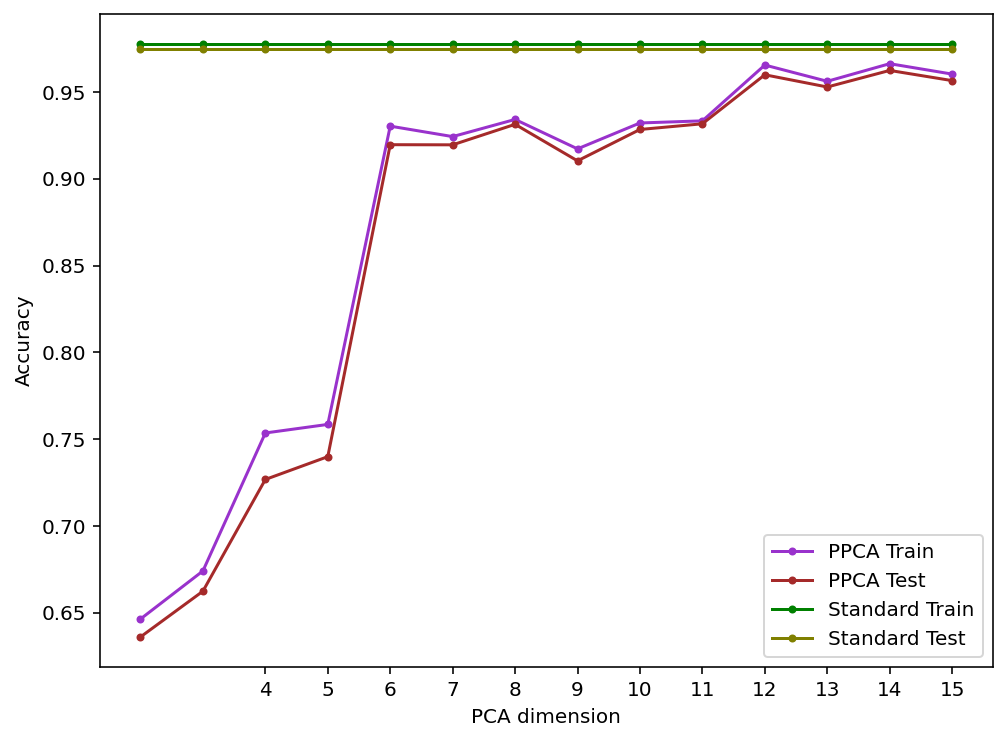

In [467]:
plot_pca_compare(pca_compare_IIbc, avg_raw_bcII)

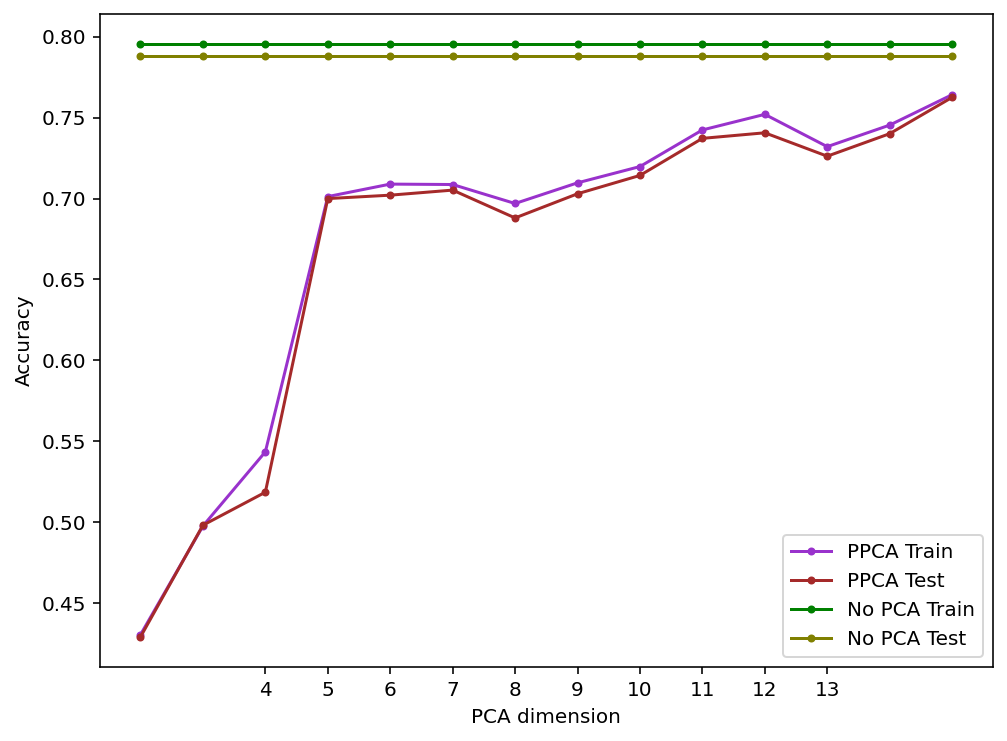

In [446]:
plot_pca_compare(pca_compare_16, avg_no_pca_sims)

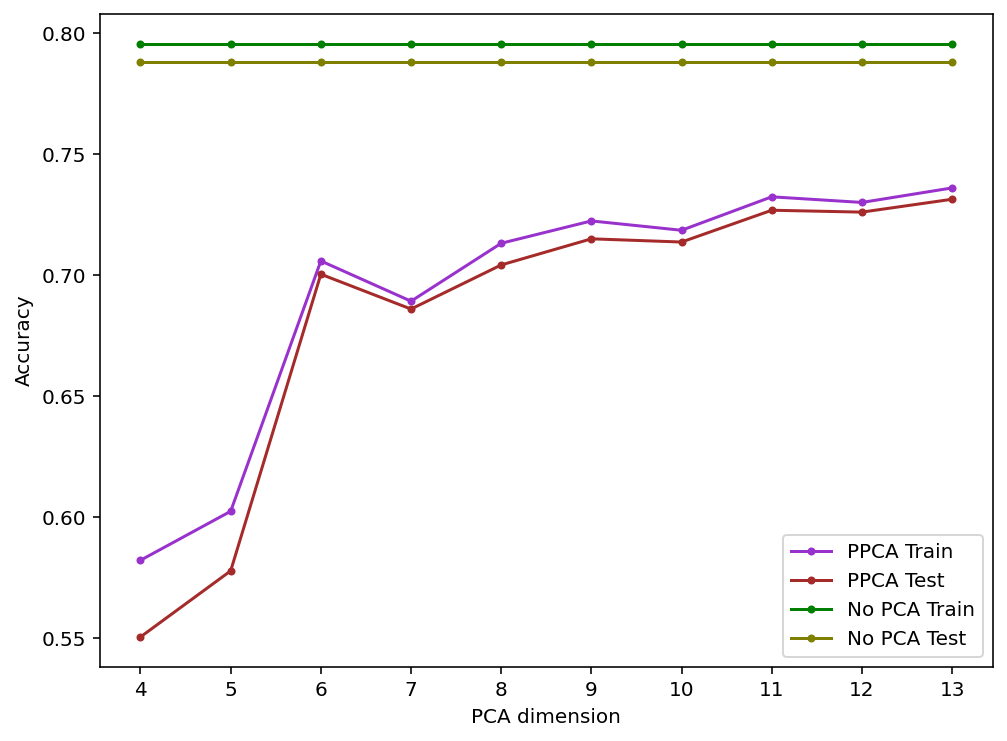

In [233]:
plot_pca_compare(pca_compare_with_2, avg_no_pca_sims)

[0.9759197324414716, 0.9759197324414716, 0.9759197324414716, 0.9759197324414716, 0.9759197324414716, 0.9759197324414716, 0.9759197324414716, 0.9759197324414716, 0.9759197324414716, 0.9759197324414716]
[0.9350055741360089, 0.9350055741360089, 0.9350055741360089, 0.9350055741360089, 0.9350055741360089, 0.9350055741360089, 0.9350055741360089, 0.9350055741360089, 0.9350055741360089, 0.9350055741360089]


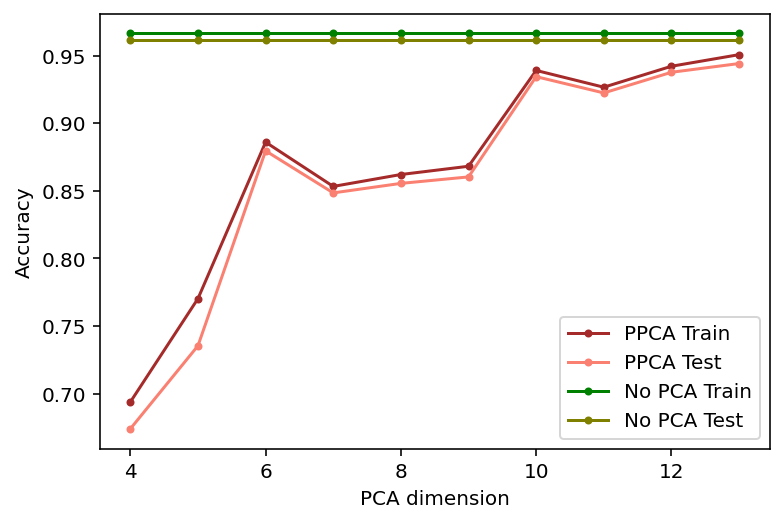

In [196]:
plot_pca_compare(pca_omit_2, average_raw_no_II)

In [249]:
res_pca_online = apply_ppca(real, labels, sim, sim_labels, use_sim_only=use_sim_only, hyperparams=hyperparams, shuffle=shuffle, pca_num=16)

RESULTS FOR PPCA
training accuracy, ppca 0.7655675746122769
testing accuracy, ppca 0.7600281491907108
